# 05 :: UMAP embedding of the spots

In [1]:
# %load common.py
import pandas as pd
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Commonly used constants.

slides = [
    'B02_D1', 'B02_E1', 'B03_C2', 'B03_D2', 'B04_D1',
    'B04_E1', 'B05_D2', 'B05_E2', 'B06_E1', 'B07_C2',
    'N02_C1', 'N02_D1', 'N03_C2', 'N03_D2', 'N04_D1',
    'N04_E1', 'N05_C2', 'N05_D2', 'N06_D2', 'N07_C1']

GT = 'GT'
YEN = 'AB1_StdDev_Yen'
REGION = 'Region_predict'
ASTROCYTE = 'astrocyte'
NEURON = 'neuron'
INTERNEURON = 'interneuron'
AGE = 'age'
DAYS = 'age_days'
MONTHS = 'age_months'
AGE_GT ='age_GT'
SAMPLE_ID = 'sampleID'
SPOT_UID = 'spot_UID'
SLIDE_ID = 'slide_ID'

# The merged data file in Parquet format.

parquet = '/media/tmo/data/work/datasets/02_ST/parquet/'
st_full = parquet + 'st_full'

def read_full(path=st_full):
    return pd.read_parquet(st_full)

def enrich(full):
    # Add age column (young, old)
    full[AGE] = np.where(full[MONTHS] < 10, 'young', 'old')
    
    # Add combined column age_GT.
    full[AGE_GT] = full[[AGE, GT]].apply(lambda x: '_'.join(x), axis=1)
    
    # parse slide ID
    full['slide_ID'] = full[SPOT_UID].apply(lambda x: str(x).split('__')[0])
    
    return full

def read_enriched(path=st_full):
    return enrich(read_full(path))
    
# TODO
# * add 'coarse_region' that joins regions with <500 entries in them into one region OTHER

In [2]:
from umap import UMAP

* **TODO** clean up categorical data in a better way

In [5]:
full = read_enriched()

In [6]:
slide_id2nr_map = dict(zip(list(full['slide_ID'].unique()), range(0,20)))

full['slide_nr'] = full[SLIDE_ID].apply(lambda x: slide_id2nr_map[x] )

In [7]:
n_genes = 46454

In [8]:
gene_cols = full.columns[1:n_genes+1]

In [9]:
ex_matrix = full[gene_cols].as_matrix()

In [10]:
ex_matrix.shape

(10327, 46454)

In [11]:
ex_matrix_KI = full[full['GT'] == 'KI'][gene_cols].as_matrix()

In [12]:
full['GT'] = full['GT'].astype('category', copy=False)
full['GT'].dtype

CategoricalDtype(categories=['KI', 'WT'], ordered=False)

In [13]:
full[AGE_GT] = full[AGE_GT].astype('category', copy=False)
full[AGE_GT].dtype

CategoricalDtype(categories=['old_KI', 'old_WT', 'young_KI', 'young_WT'], ordered=False)

In [14]:
full[AGE] = full[AGE].astype('category', copy=False)
full[AGE].dtype

CategoricalDtype(categories=['old', 'young'], ordered=False)

---

### Genes ranked by leverage
* read from .tsv file

In [16]:
ranked_gene_lev_df = pd.read_csv('ranked_gene_leverage.tsv', sep='\t', index_col=0)

In [17]:
ranked_gene_lev_df.head()

,gene,leverage
18440,Gm26228,0.039117
23867,Gm44074,0.035930
15575,Gm21956,0.035028
32402,Mir8105,0.034804
43965,Trim50,0.033270


In [18]:
lev_ranked_genes = ranked_gene_lev_df.gene.values

In [19]:
lev_ranked_genes[:5]

array(['Gm26228', 'Gm44074', 'Gm21956', 'Mir8105', 'Trim50'], dtype=object)

In [20]:
lev_top = 500
ex_matrix_lev_top = full[lev_ranked_genes[:lev_top]]

In [21]:
ex_matrix_lev_top.head()

,Gm26228,Gm44074,Gm21956,Mir8105,Trim50,Gm27221,Skor2,Sppl2c,Gm18301,Gm26599,...,Gsdma3,Ndn,Tpt1,Grik3,Prdm8,Cdhr3,Hbb-bt,Chgb,Trem2,C1qb
0,-0.041451,-0.090424,-0.041451,-0.041451,-0.1166,-0.041451,-0.161419,-0.076991,-0.041451,-0.06885,...,-0.041451,-0.223632,-0.667010,0.338355,-1.354164,-0.258967,0.552751,-0.048359,-0.809422,0.342185
1,-0.041451,-0.090424,-0.041451,-0.041451,-0.1166,-0.041451,-0.161419,-0.076991,-0.041451,-0.06885,...,-0.041451,1.663933,-1.063469,0.307048,0.705657,-0.258967,0.519507,-0.778656,-0.809422,-1.641906
2,-0.041451,-0.090424,-0.041451,-0.041451,-0.1166,-0.041451,-0.161419,-0.076991,-0.041451,-0.06885,...,-0.041451,0.300919,0.363090,0.382765,-1.354164,-0.258967,-1.500903,-0.793601,-0.809422,0.393226
3,-0.041451,-0.090424,-0.041451,-0.041451,-0.1166,-0.041451,-0.161419,-0.076991,-0.041451,-0.06885,...,-0.041451,1.651561,0.784157,-1.063567,0.264832,-0.258967,0.403224,-1.054527,1.230739,-1.641906
4,-0.041451,-0.090424,-0.041451,-0.041451,-0.1166,-0.041451,-0.161419,-0.076991,-0.041451,-0.06885,...,-0.041451,-0.213497,0.122269,0.852340,1.111550,-0.258967,1.880452,0.502533,0.697934,0.916713


---

* unfortunately, UMAP is single-threaded
* running time @ 2.2Ghz, 1 cpu = 1h55
* cause of bad performance is high dimensionality
* https://matplotlib.org/examples/color/colormaps_reference.html

In [22]:
%%time
embedding_lev_top = UMAP(n_neighbors=5,
                         min_dist=0.3, 
                         spread=1,
                         random_state=666,
                         metric='minkowski',
                         metric_kwds={'p': 0.5}).fit_transform(ex_matrix_lev_top)

CPU times: user 1min 8s, sys: 19.1 s, total: 1min 27s
Wall time: 42.4 s


In [23]:
embedding_df = pd.DataFrame(embedding_lev_top, columns=['x', 'y'])

In [24]:
full['GT'].cat.categories

Index(['KI', 'WT'], dtype='object')

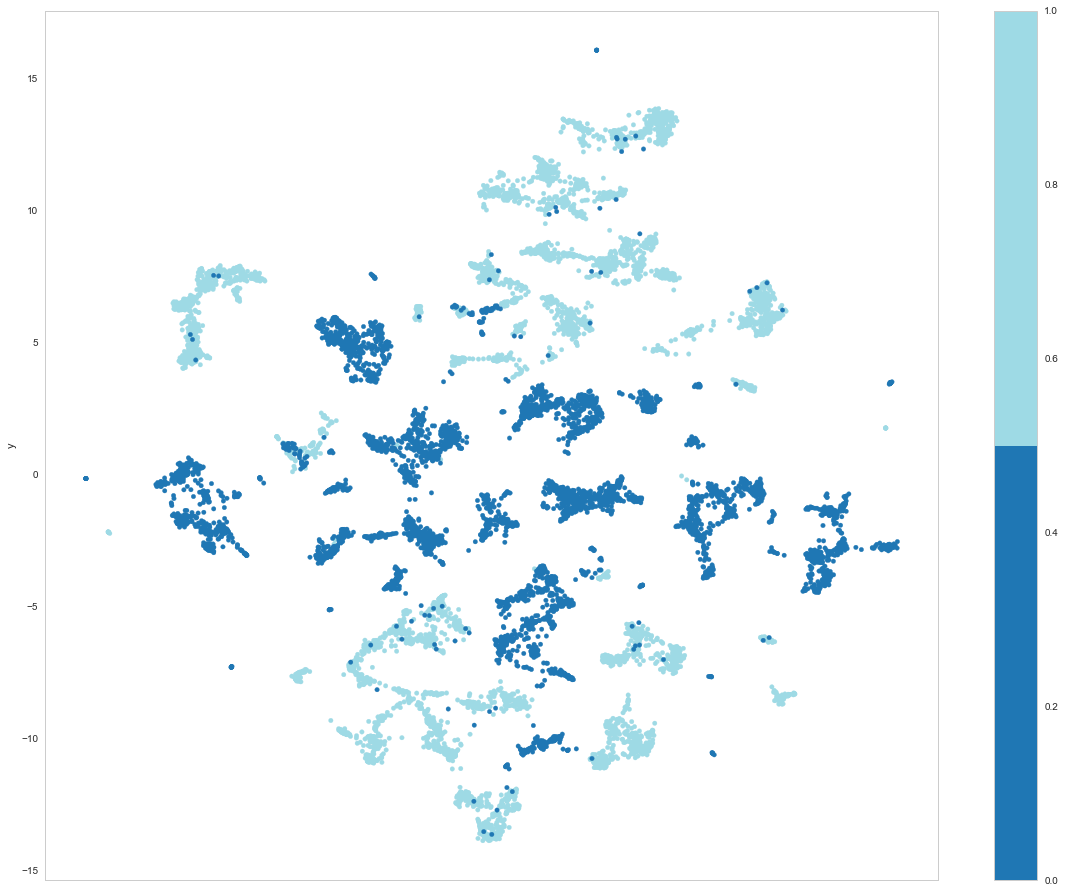

In [25]:
ax = embedding_df.plot.scatter(figsize=(20, 16), x='x', y='y', alpha=1, c=full[GT].cat.codes, cmap=plt.cm.get_cmap('tab20', 2))
ax.grid(False)
plt.show()

In [26]:
full[AGE].cat.categories

Index(['old', 'young'], dtype='object')

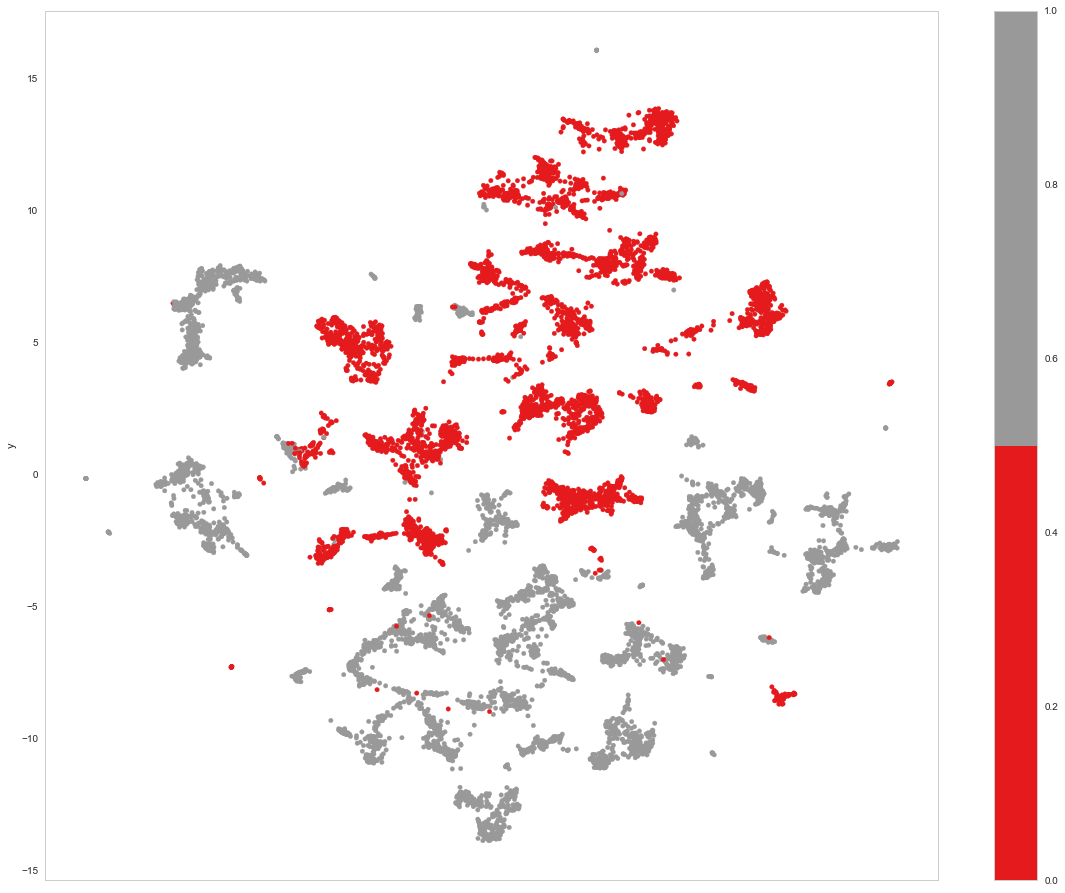

In [27]:
ax = embedding_df.plot.scatter(figsize=(20, 16), x='x', y='y', alpha=1, c=full[AGE].cat.codes, cmap=plt.cm.get_cmap('Set1', 2))
ax.grid(False)
plt.show()

In [28]:
full[AGE_GT].cat.categories

Index(['old_KI', 'old_WT', 'young_KI', 'young_WT'], dtype='object')

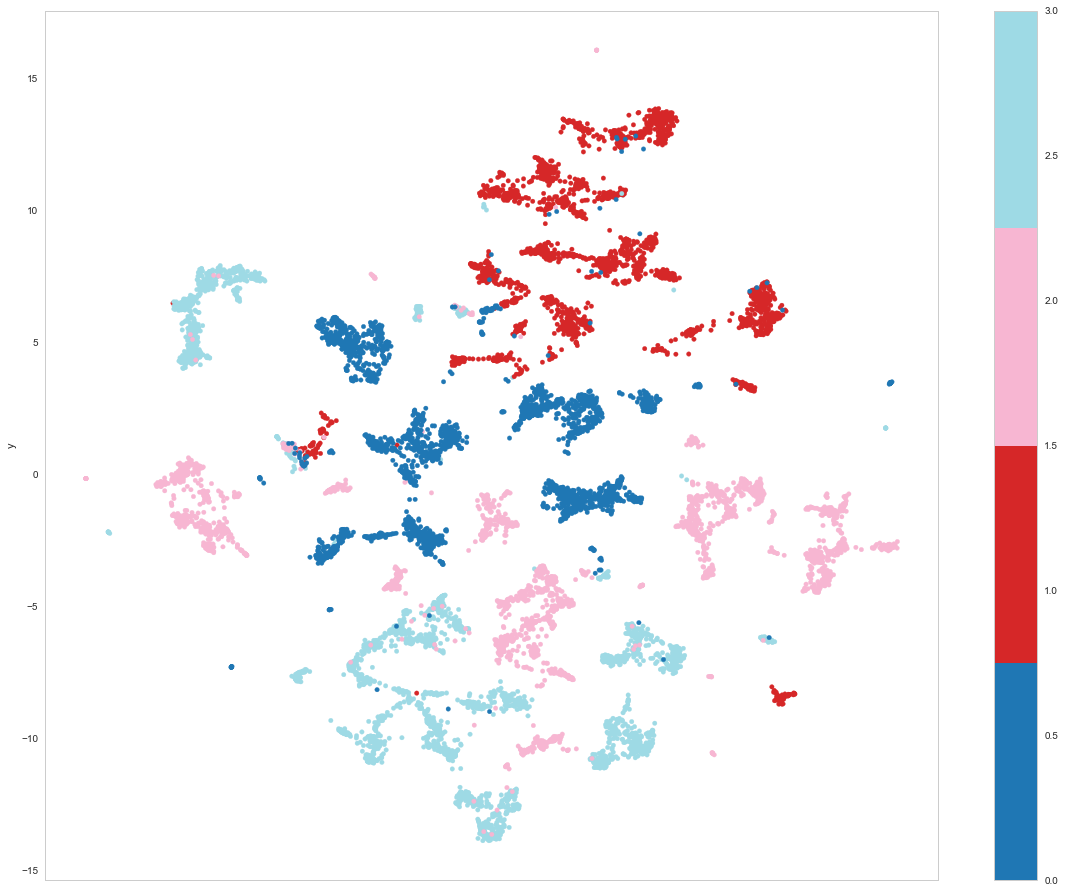

In [29]:
ax = embedding_df.plot.scatter(figsize=(20, 16), x='x', y='y', alpha=1, c=full[AGE_GT].cat.codes, cmap=plt.cm.get_cmap('tab20', 4))
ax.grid(False)
plt.show()

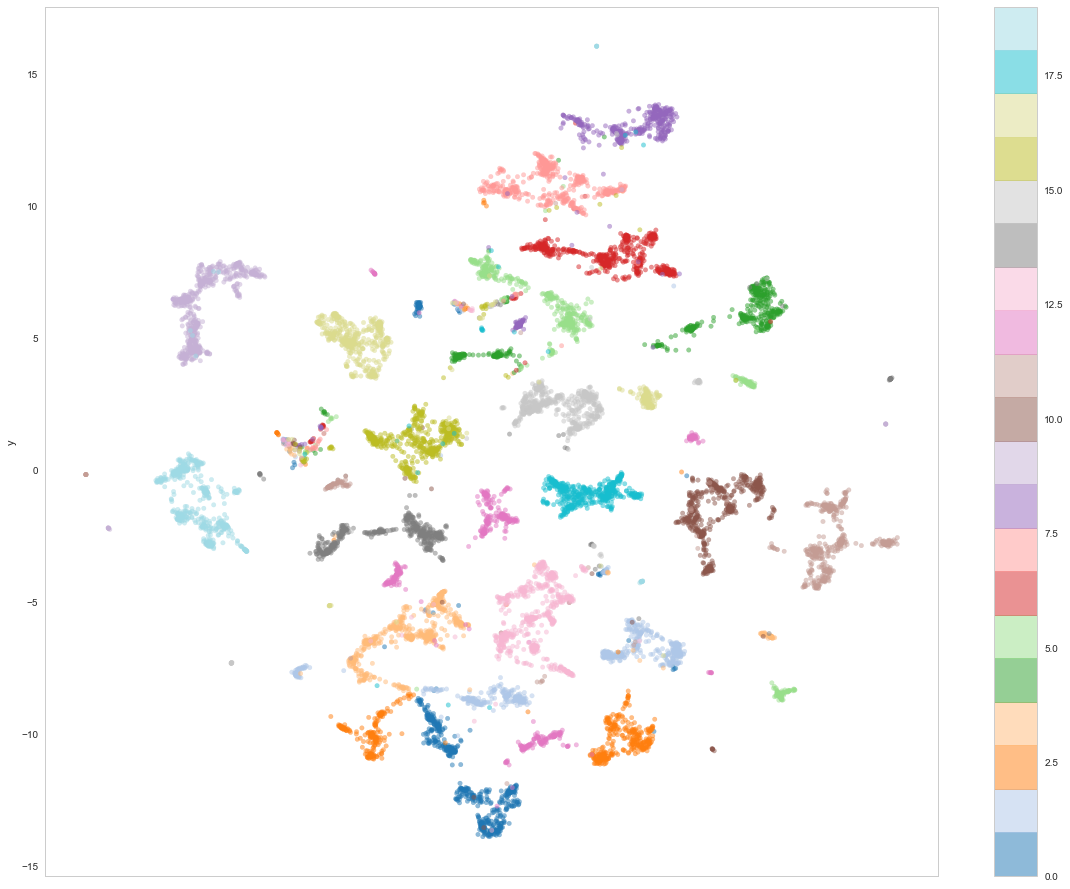

In [30]:
ax = embedding_df.plot.scatter(figsize=(20, 16), x='x', y='y', alpha=0.5, c=full['slide_nr'].values, cmap=plt.cm.get_cmap('tab20'))
ax.grid(False)
plt.show()

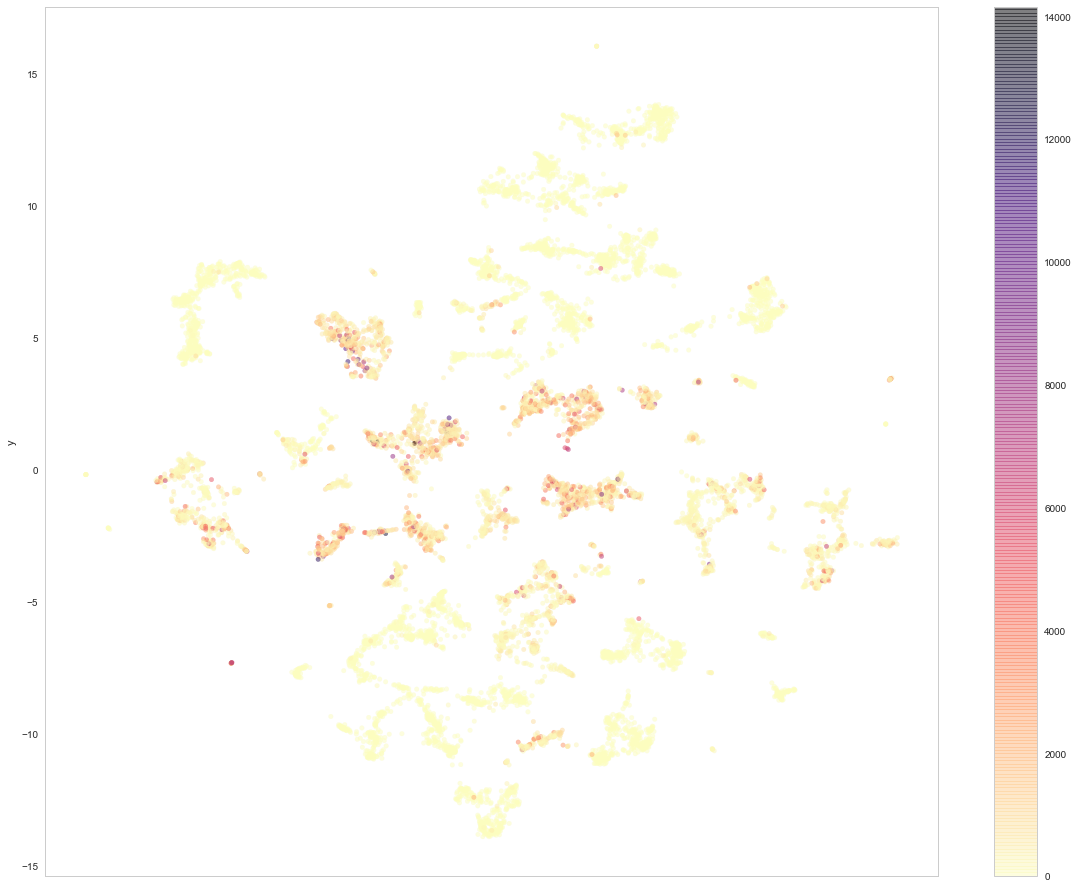

In [31]:
ax = embedding_df.plot.scatter(figsize=(20, 16), x='x', y='y', alpha=0.5, c=full[YEN], cmap=plt.cm.get_cmap('magma_r'))
ax.grid(False)
plt.show()

---

---

---

In [ ]:
# %%time
# embedding = UMAP(n_neighbors=5,
#                  min_dist=0.3,
#                  metric='euclidean').fit_transform(ex_matrix)

In [15]:
embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])

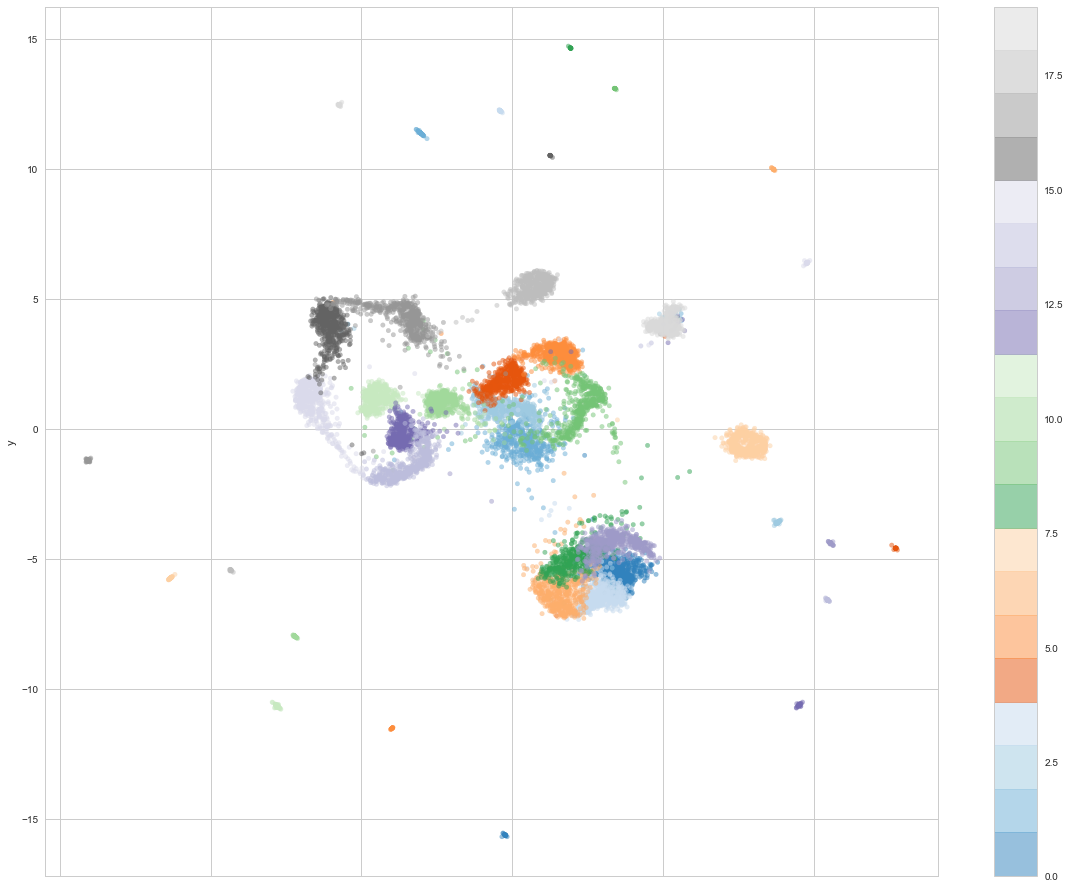

In [52]:
embedding_df.plot.scatter(figsize=(20, 16), x='x', y='y', alpha=0.5, c=full['slide_nr'].values, cmap='tab20c')
plt.show()

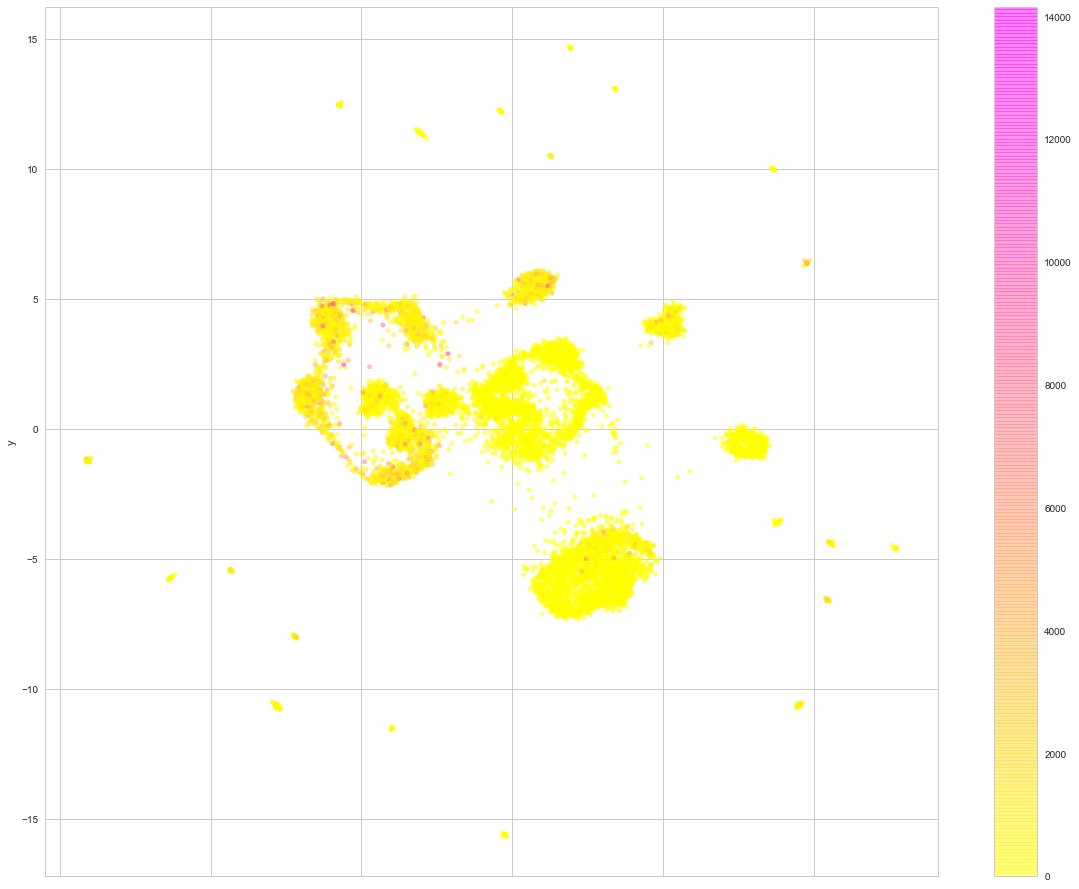

In [76]:
embedding_df.plot.scatter(figsize=(20, 16), x='x', y='y', alpha=0.5, c=full['AB1_StdDev_Yen'], cmap='spring_r')
plt.show()

# Embedding of GT==KI entries

In [87]:
%%time
embedding_KI = UMAP(n_neighbors=5,
                    min_dist=0.9,
                    metric='euclidean').fit_transform(ex_matrix_KI)

CPU times: user 35min 16s, sys: 38.9 s, total: 35min 55s
Wall time: 35min 34s


In [88]:
embedding_KI_df = pd.DataFrame(embedding_KI, columns=['x', 'y'])

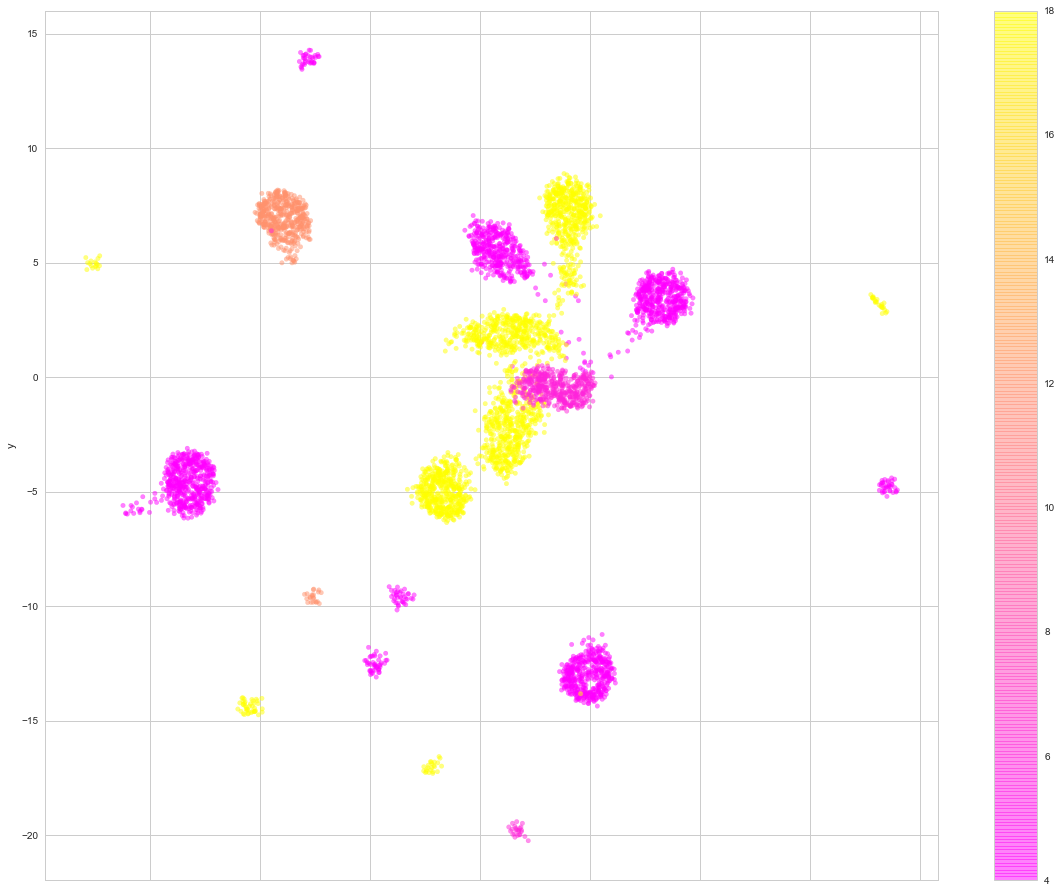

In [100]:
embedding_KI_df.plot.scatter(figsize=(20, 16), x='x', y='y', c=full[full['GT'] == 'KI']['age_months'], cmap="spring", alpha=0.5)
plt.show()

In [12]:
%%time
embedding_cos = UMAP(n_neighbors=5,
                     min_dist=0.3,
                     metric='cosine').fit_transform(ex_matrix)

CPU times: user 1h 53min 36s, sys: 2min 36s, total: 1h 56min 12s
Wall time: 1h 55min 40s


In [121]:
ex_matrix_KI_top_cols = full[full['GT'] == 'KI'][top_cols].as_matrix()

In [123]:
ex_matrix_KI_top_cols.shape

(5009, 500)

In [141]:
%%time
embedding_KI_top_cols = UMAP(n_neighbors=5,
                             min_dist=0.3,
                             metric='manhattan').fit_transform(ex_matrix_KI_top_cols)

CPU times: user 31.9 s, sys: 7.14 s, total: 39 s
Wall time: 19.3 s


In [142]:
embedding_KI_top_cols_df = pd.DataFrame(embedding_KI_top_cols, columns=['x', 'y'])

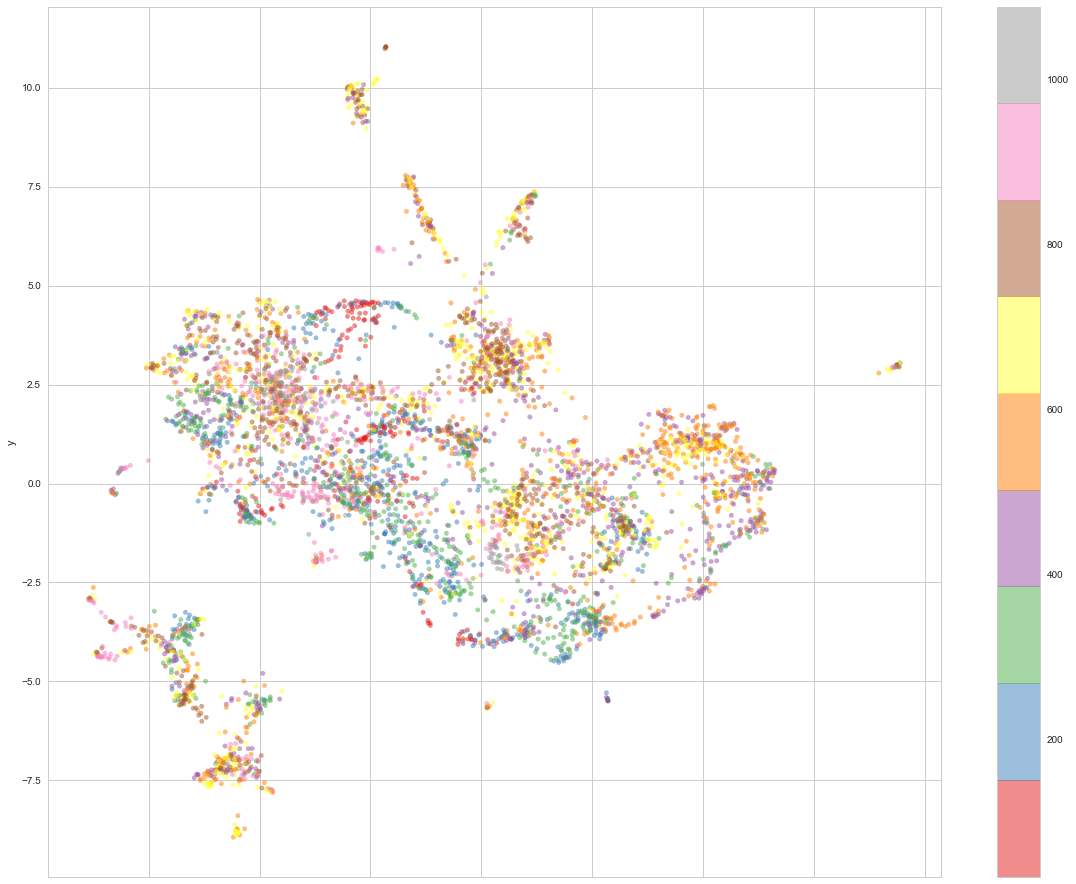

In [143]:
embedding_KI_top_cols_df.plot.scatter(figsize=(20, 16), x='x', y='y', c=full[full['GT'] == 'KI']['spot_ID'], cmap="Set1", alpha=0.5)
plt.show()

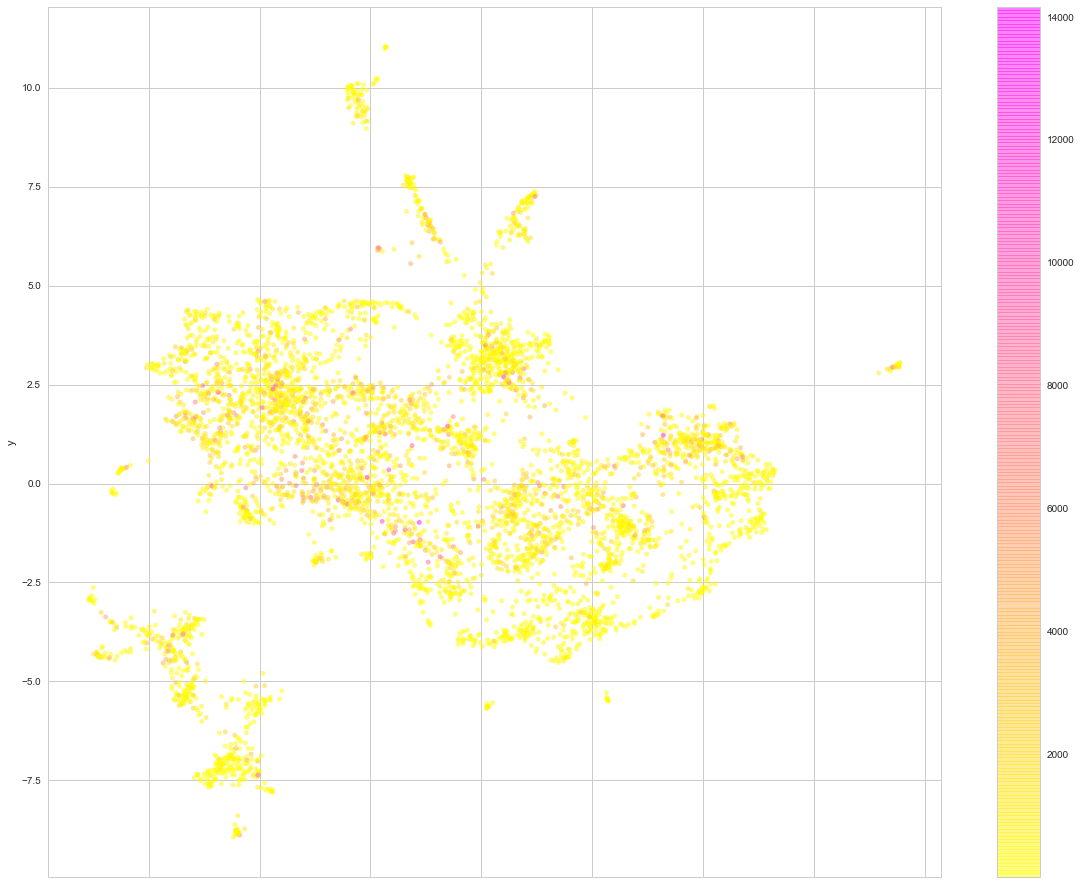

In [146]:
embedding_KI_top_cols_df.plot.scatter(figsize=(20, 16), x='x', y='y', c=full[full['GT'] == 'KI']['AB1_StdDev_Yen'], cmap="spring_r", alpha=0.5)
plt.show()